# Scalable Inference with a Sparse GP 

## Optional Preparation
**Warning:** This tutorial assumes you have familiarity with Gaussian Processes and their implementations in stochastic variational inference. It may help if you do the following:
1. Read the [Non-Gaussian Likelihoods][1] `tinygp` tutorial, we will be starting from the end of this tutorial for continuity.
2. Familiarize yourself with stochastic variational inference (see [Appendix A](#appendix-a-svi-basics)). 
3. Familiarize yourself with sparse gaussian processes (see [Appendix B][B] below).

<!-- ### Reference: -->

[1]: <https://tinygp.readthedocs.io/en/latest/tutorials/likelihoods.html> "Scalable Variational Gaussian Process Classification"
[1]: <https://proceedings.mlr.press/v38/hensman15.pdf> "Scalable Variational Gaussian Process Classification"

## Example: Non-Gaussian Likelihood Fit (Similar to `tinygp` Tutorial)

### Generate Poisson Data

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


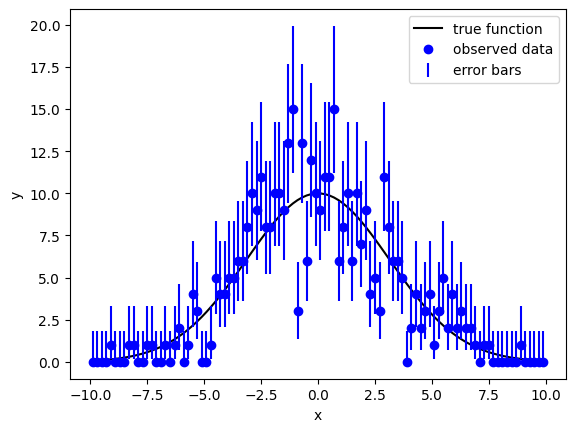

In [1]:
import sys
sys.path.append("..")
from utils import custom
from utils.custom import log_like_poisson

import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
import tqdm

import jax # for faster numerical operations
import jax.numpy as jnp # for numpy-like syntax
from jax.scipy import stats
from jax import jit

from tinygp import GaussianProcess, kernels
import numpyro # for inference and probabilistic programming
import numpyro.distributions as dist
from numpyro.infer import Predictive

# parameters
p_tr = [0., np.pi, 10.]
mu_tr, sigma_tr, N_tr = p_tr

# generate data
x_bin = jnp.linspace(-10,10,101) # 10 random points between -1 and 1
x = 0.5 * (x_bin[:-1] + x_bin[1:])
log_rate = -(x-mu_tr)**2. / (2. * sigma_tr**2.)
y = N_tr * jnp.exp(log_rate)
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y)

# estimate error bars
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs.T]).T

# plot data with error bars
plt.plot(x, y, 'k', label='true function')
plt.plot(x, y_obs, 'bo', label='observed data')
plt.errorbar(x, y_obs, yerr = yerr, c = 'b', fmt = 'none', label='error bars')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Build model and run SVI 

In [5]:
jax.config.update("jax_enable_x64", True)

# Unconstrained SVI fit
def model(x, y=None):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    y : array
        y values (observations)
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define Gaussian Process prior on log_rate (zero mean and ExpSquared kernel)
    gp = GaussianProcess(kernel, x, diag = 1e-3)
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())
    rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor('log_likelihood', log_like_poisson(rate, y))

In [9]:
# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = svi.run(rng_key, 30000, x, y=y_obs)

100%|██████████| 30000/30000 [00:27<00:00, 1084.11it/s, init loss: 69850.7384, avg. loss [28501-30000]: 186.3747]


In [10]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
samples = guide.sample_posterior(key, svi_results.params, (1000,))
gp_samples = jnp.exp(samples['log_rate'])

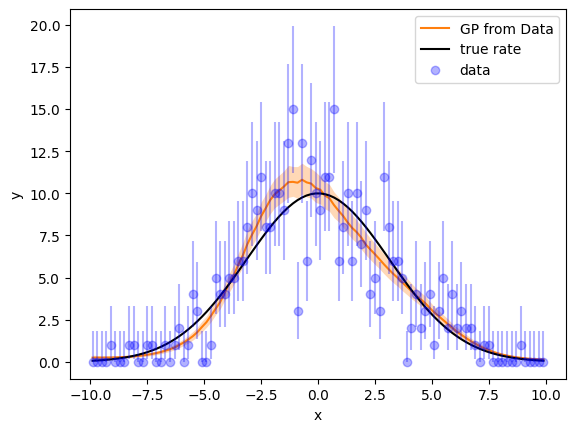

In [11]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
plt.plot(x, q[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q[0],
    q[2],
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, "bo", label="data", alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'b', fmt = 'none', alpha = 0.3)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

### Try fit with 5x Datapoints

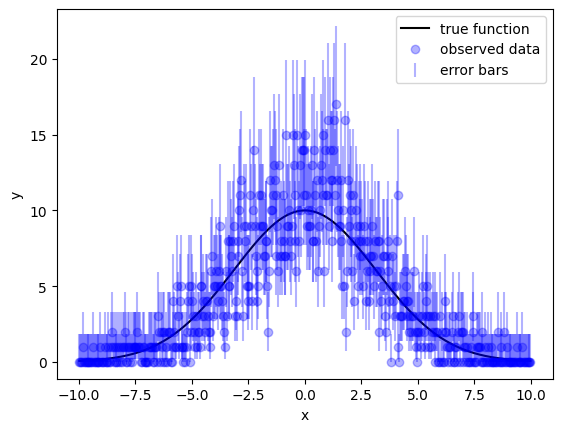

In [12]:
# generate data
x_bin = jnp.linspace(-10,10,501) # 10 random points between -1 and 1
x = 0.5 * (x_bin[:-1] + x_bin[1:])
log_rate = -(x-mu_tr)**2. / (2. * sigma_tr**2.)
y = N_tr * jnp.exp(log_rate)
y_obs = jax.random.poisson(jax.random.PRNGKey(23),y)

# estimate error bars
yerr = jnp.array([custom.poisson_interval(k) for k in y_obs.T]).T

# plot data with error bars
plt.plot(x, y, 'k', label='true function')
plt.plot(x, y_obs, 'bo', label='observed data', alpha = 0.3)
plt.errorbar(x, y_obs, yerr = yerr, c = 'b', fmt = 'none', label='error bars', alpha = 0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [13]:
# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = svi.run(rng_key, 30000, x, y=y_obs)

100%|██████████| 30000/30000 [01:45<00:00, 283.70it/s, init loss: 320002.6127, avg. loss [28501-30000]: 949.6871]


In [14]:
# sample from GP posterior using guide sample_posterior function
rng_key, key = jax.random.split(rng_key)
samples = guide.sample_posterior(key, svi_results.params, (1000,))
gp_samples = jnp.exp(samples['log_rate'])

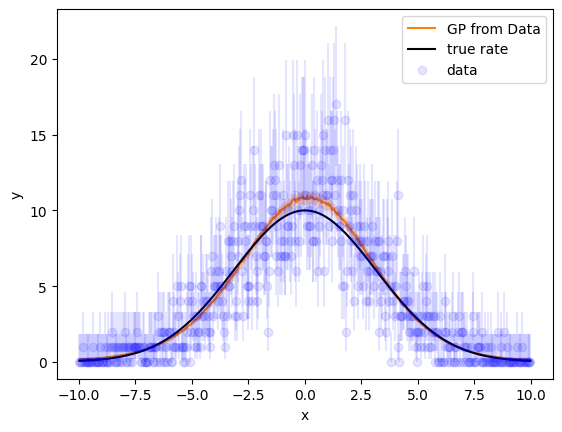

In [15]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
# plt.plot(x_sub, np.exp(mu), color="C0", label="VI inferred rate")
plt.plot(x, q[1], color = 'C1', label = 'GP from Data')
plt.fill_between(
    x,
    q[0],
    q[2],
    alpha=0.3,
    lw=0,
    color="C1",
)

# plot data with error bars 
plt.plot(x, y, "k", label="true rate")
plt.plot(x, y_obs, "bo", label="data", alpha = 0.1)
plt.errorbar(x, y_obs, yerr = yerr, c = 'b', fmt = 'none', alpha = 0.1)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

### Sparse GP Implementation
Due to the higher number of datapoints, the fit requires more time and memory to complete. The sparse GP implementation would improve both the time and memory of the fit. 

In [16]:
def model(x, xu, y=None):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    xu : array
        x values of inducing points
    y : array
        y values (observations)
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define GP on inducing points
    gp_u = GaussianProcess(kernel, xu, diag = 1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())
    
    # sample GP at x from inducing point samples
    _, gp_x = gp_u.condition(log_rate_u, x, diag=1e-3)
    log_rate = gp_x.sample(key = jax.random.PRNGKey(12))
    rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y)) 

In [17]:
# define inducing points
xu = jnp.linspace(-10,10,20)

# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = svi.run(rng_key, 30000, x, xu=xu, y=y_obs)

100%|██████████| 30000/30000 [01:20<00:00, 374.71it/s, init loss: 12901.4262, avg. loss [28501-30000]: 860.2006]


In [18]:
# sample from GP posterior using guide sample_posterior function
pred = Predictive(guide, num_samples = 1000, params = svi_results.params)
rng_key, key = jax.random.split(rng_key)
samples = pred(key, x, xu, y=None)

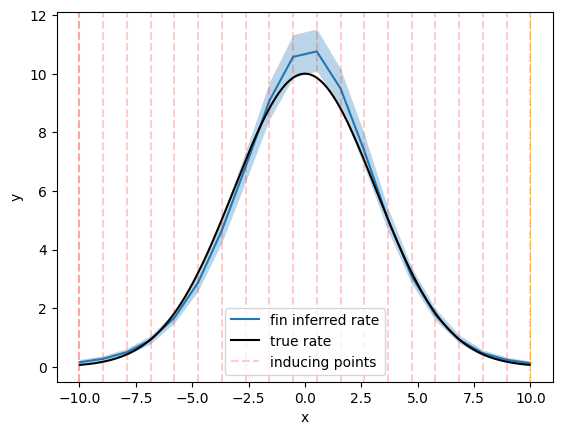

In [19]:
u_samples = jnp.exp(samples["log_rate_u"])
q = np.percentile(u_samples, [5, 50, 95], axis=0)


# plot guide (posterior approximation)
plt.plot(xu, q[1], color="C0", label="fin inferred rate")
plt.fill_between(xu, q[0], q[2], alpha=0.3, lw=0, color="C0")

# plot data with crude error bars 
plt.plot(x, y, "k", label="true rate")

for xu_v in xu:
    if xu_v == xu[0]:
        g = plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2, label = 'inducing points')
    g = plt.axvline(xu_v, color="red", linestyle="--", alpha=0.2)
plt.axvline(x = xu_v, c = 'orange', ls = '--', lw = 0.5)
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

Guide can only be used to draw samples of the inducing points, so we need to convert from that to GP values. We do this by conditioning the GP on the inducing points and then sampling from the GP. Two ways that I have done this involve drawing

In [20]:
# sample the GP at x using custom (vectorized) sampler
pred = Predictive(guide, num_samples = 1, params = svi_results.params)
gp_samples = custom.get_gp_samples_at_x_from_u(rng_key, 1000, pred, svi_results.params, x, xu)

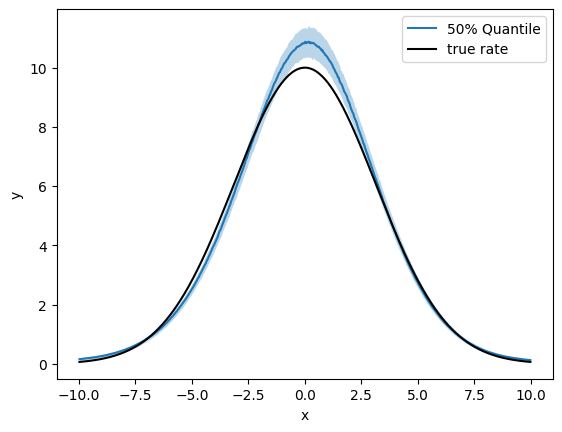

In [21]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
# plt.plot(x_sub, np.exp(mu), color="C0", label="VI inferred rate")
plt.plot(x, np.exp(q[1]), color = 'C0', label = '50% Quantile')
plt.fill_between(
    x,
    np.exp(q[0]),
    np.exp(q[2]),
    alpha=0.3,
    lw=0,
    color="C0",
)

# plot data with crude error bars 
plt.plot(x, y, "k", label="true rate")
# plt.plot(x, y_obs, "bo", label="data")
# plt.errorbar(x, y_obs, yerr = np.sqrt(y), c = 'b', fmt = 'none', label='error bars')
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

#### Subtle Issue:
During our SVI fit, the same random seed is being used to convert the inducing point sample `log_rate_u` to the desired sample `log_rate`. See the code block below.
````
# load kernel and sample from GP
_, gp_x = gp_u.condition(log_rate_u, x, diag=1e-3)
log_rate = gp_x.sample(key = jax.random.PRNGKey(12))
rate = jnp.exp(log_rate)
````
**Note:** We cannot bypass this problem by using `np.random.randint` to generate the integer in the argument of `jax.random.PRNGKey`. 

To fix this problem, we have to manually update the `PRNGKey` at each SVI step. Instead of modifying `svi.run` to allow for this, we make a bare-bones function that runs the SVI algorithm with the desired `PRNGKey` manual updates.


In [2]:
def model(x, xu, y=None, gp_rng_key = jax.random.PRNGKey(0)):
    '''
    Numpyro model for 1D Poisson regression with Gaussian Process prior on log_rate

    Parameters
    ----------
    x : array
        x values (where observations are made)
    xu : array
        x values of inducing points
    y : array
        y values (observations)
    gp_rng_key : PRNGKey
        random key for sampling from GP
    '''
    # define GP kernel (with hyperparameters optimized during fitting)
    kernel = custom.load_kernel(before_fit = True)

    # define GP on inducing points
    gp_u = GaussianProcess(kernel, xu, diag = 1e-3)
    log_rate_u = numpyro.sample("log_rate_u", gp_u.numpyro_dist())
    
    # sample GP at x from inducing point samples
    _, gp_x = gp_u.condition(log_rate_u, x, diag=1e-3)
    log_rate = gp_x.sample(key = gp_rng_key)
    rate = jnp.exp(log_rate)
    
    # load function values and compute log likelihood
    numpyro.factor("log_likelihood", log_like_poisson(rate, y)) 

In [3]:
# define inducing points
xu = jnp.linspace(-10,10,20)

# run SVI
svi, guide = custom.load_svi(model, lr = 0.01, num_particles = 16)
rng_key = jax.random.PRNGKey(0)
svi_results = custom.svi_loop(rng_key, 30000, svi, x, xu, y_obs)

100%|██████████| 30000/30000 [00:28<00:00, 1058.38it/s]


In [5]:
# sample the GP at x using custom (vectorized) sampler
pred = Predictive(guide, num_samples = 1, params = svi_results.params)
gp_samples = custom.get_gp_samples_at_x_from_u(rng_key, 1000, pred, svi_results.params, x, xu)

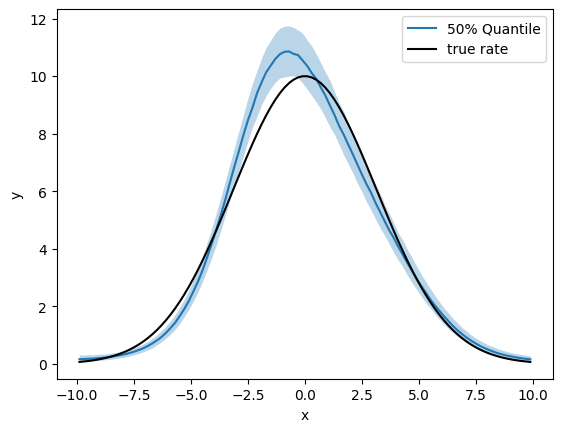

In [6]:
q = np.quantile(gp_samples, [0.16,0.5,0.84], axis = 0)

# plot guide (posterior approximation)
# plt.plot(x_sub, np.exp(mu), color="C0", label="VI inferred rate")
plt.plot(x, np.exp(q[1]), color = 'C0', label = '50% Quantile')
plt.fill_between(
    x,
    np.exp(q[0]),
    np.exp(q[2]),
    alpha=0.3,
    lw=0,
    color="C0",
)

# plot data with crude error bars 
plt.plot(x, y, "k", label="true rate")
# plt.plot(x, y_obs, "bo", label="data")
# plt.errorbar(x, y_obs, yerr = np.sqrt(y), c = 'b', fmt = 'none', label='error bars')
plt.legend()
plt.xlabel("x")
_ = plt.ylabel("y")

## Appendix A: SVI Basics 

In inference, the basic objective is to develop the best model to explain the available data. The model is defined by observations $x$, latent variables $z$, and parameters $\theta$ distinguishing the model from other models:
\begin{align}
    p_{\theta}(x) = \int p_{\theta}(x,z) \ dz.
\end{align}
Therefore, the objective is achieved by finding the parameter that optimizes the log-evidence:
\begin{align}
    \theta^{*} = \argmax_{\theta} \log p_{\theta}(x).
\end{align}

With the optimal model, we also want to be able to make predictions and estimate uncertainties on the latent variables. That is, we want the posterior $p_{\theta}(z|x)$, which is generally intractable. Stochastic variational inference (SVI) is a scheme for getting around this. One defines the variational distribution (guide) $q_{\phi}(z) \sim p_{\theta}(z|x)$. This condition can be written as:
\begin{equation}
    \phi^{*} = \argmin_{\phi} KL[ \ q_{\phi}(z) \ || \ p_{\theta}(z|x) \ ].
\end{equation}

Therefore, by performing SVI, we are trying to simultaneously find the best model and the best approximation to the posterior. A good start to doing this would be to replacing the posterior in the KL-term above with something more tractable (think in terms of joint distribution).

\begin{align}
    KL[ \ q_{\phi}(z) \ || \ p_{\theta}(z|x) \ ] & = \mathbb{E}_{q(z)} \left [ \log \frac{q(z)}{p(z|x)} \right ] \\
    & = \mathbb{E}_{q(z)} \left [ \log q(z) \right ] - \overset{p(z|x) = p(z,x)/p(x)}{\overline{\mathbb{E}_{q(z)} \left [ \log p(z|x) \right ]}} \\
    & = \mathbb{E}_{q(z)} \left [ \log q(z) \right ] - \mathbb{E}_{q(z)} \left [ \log p(z,x) \right ] +  \underset{\log p(x)}{\underline{\mathbb{E}_{q(z)} \left [ \log p(x) \right ]}}, 
\end{align}
We now have a relationship between the evidence and the similarity between the guide and the true posterior:
\begin{equation}
    \log p_{\theta}(x) = \underset{ELBO}{\underline{\mathbb{E}_{q(z)}\left [ \log p(x,z) - \log q(z) \right ]}} + KL[ \ q_{\phi}(z) \ || \ p_{\theta}(z|x) \ ],
\end{equation}
where $ELBO$ denotes the *{Evidence Lower Bound* (ELBO). This will help us solve the double-optimization problem of SVI. Consider the following two properties of the ELBO:
\begin{align}
    \log p_{\theta}(x) & \geq ELBO \\
    \log p_{\theta}(x) - ELBO & = KL[ \ q_{\phi}(z) \ || \ p_{\theta}(z|x) \ ]
\end{align}
The first property implies that maximizing the ELBO will either move the ELBO closer to the log-evidence or push the log-evidence up with it. If the former occurs, then the guide becomes a better approximation of the posterior in virtue of the second property. If the latter occurs, then the model becomes better at explaining the data.

For more information on SVI, see [Variational Inference - Deriving ELBO][1] for derivation and [An Introduction to Stochastic Variational Inference in Pyro][2] for the `numpyro` implementation of SVI.

<!-- ### Reference: -->

[1]: <https://blog.jakuba.net/variational-inference-deriving-elbo/> "Variational Inference - Deriving ELBO"
[2]: <https://pyro.ai/examples/svi_part_i.html> "Scalable Variational Gaussian Process Classification"
